# Тестирование скорости
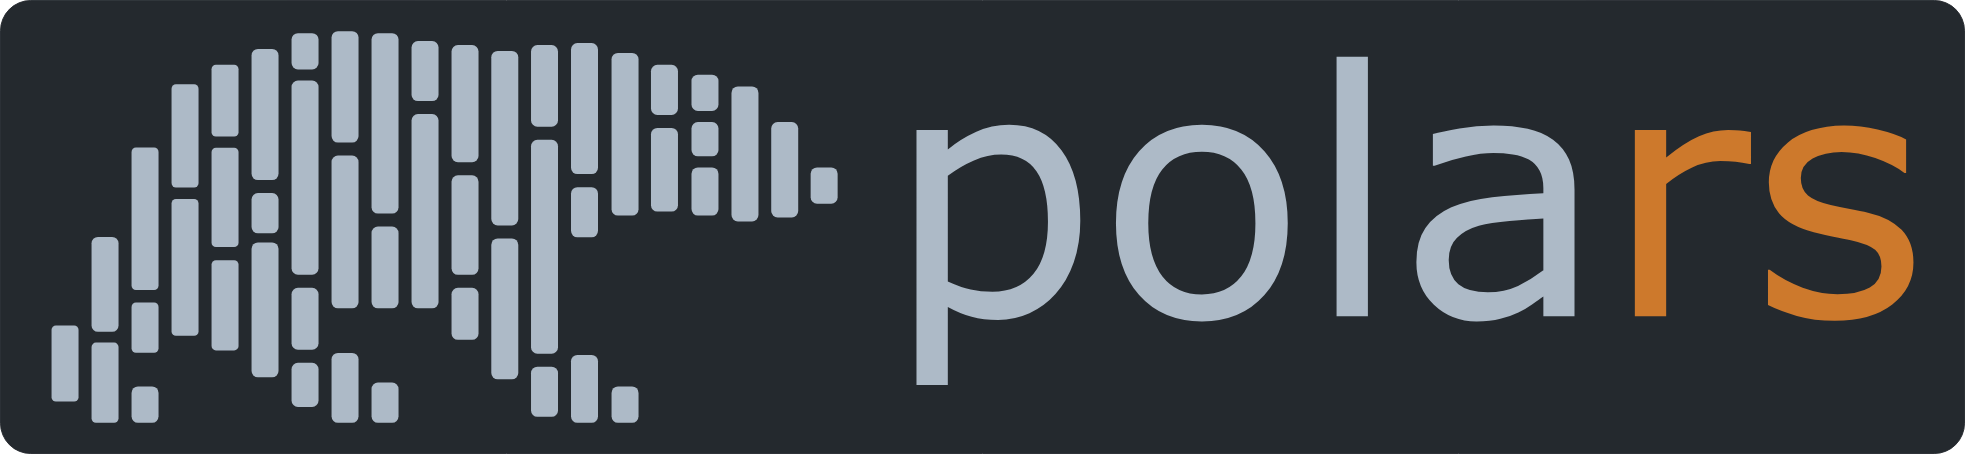

Polars - это быстрый фрэймворк для манипулирования структурированными данными. Ядро написано на Rust и доступно для Rust, Python, R и NodeJS.  

Официальный сайт - https://pola.rs/  
Руководство пользователя - https://docs.pola.rs/  
Документация The Python API reference - https://docs.pola.rs/py-polars/html/reference/index.html  
Репозиторий с большой подборкой материалов - https://github.com/ddotta/awesome-polars  

## Создание тестового датасета

In [29]:
import os
os.environ["POLARS_MAX_THREADS"] = "48"
import polars as pl
import pandas as pd
import numpy as np
from datetime import date
from faker import Faker

In [15]:
SEED=42
NUMBER_ROWS = 100_000_000
CARDINALITY = 100

In [31]:
rng = np.random.default_rng(seed=SEED)
fake = Faker()

In [32]:
df = pl.DataFrame(
    {
        "i1": rng.integers(low=0, high=100_000, size=NUMBER_ROWS, dtype=np.uint32),
        "i2": rng.integers(low=0, high=100_000_000, size=NUMBER_ROWS, dtype=np.uint64),
        "i3": rng.integers(low=-100_000, high=100_000, size=NUMBER_ROWS, dtype=np.int32),
        "i4": rng.integers(low=-100_000_000, high=100_000_000, size=NUMBER_ROWS, dtype=np.int64),
        "f1": rng.uniform(low=-100_000, high=100_000, size=NUMBER_ROWS).astype(np.float32),
        "f2": rng.uniform(low=-100_000_000, high=100_000_000, size=NUMBER_ROWS).astype(np.float64),
        "bool": rng.integers(low=0, high=1, size=NUMBER_ROWS, endpoint=True).astype(np.bool_),
        "date": pl.date_range(date(2024,1,1), date(2024,6,1), eager=True)
            .sample(n=NUMBER_ROWS, with_replacement=True, shuffle=True, seed=SEED),
        "datetime": pl.datetime_range(date(2024,1,1), date(2024,6,1), interval = '1s', eager=True)
            .cast(pl.Datetime(time_unit='ns'))
            .sample(n=NUMBER_ROWS, with_replacement=True, shuffle=True, seed=2*SEED),
        "name" : rng.choice([fake.unique.first_name() for i in range(CARDINALITY)], size=NUMBER_ROWS, replace=True)  
    }
)

In [33]:
with pl.Config(tbl_cols=10, tbl_width_chars=300):
    print(df.head(5))

shape: (5, 10)
┌───────┬──────────┬───────┬───────────┬───────────────┬───────────┬───────┬────────────┬─────────────────────┬──────────┐
│ i1    ┆ i2       ┆ i3    ┆ i4        ┆ f1            ┆ f2        ┆ bool  ┆ date       ┆ datetime            ┆ name     │
│ ---   ┆ ---      ┆ ---   ┆ ---       ┆ ---           ┆ ---       ┆ ---   ┆ ---        ┆ ---                 ┆ ---      │
│ u32   ┆ u64      ┆ i32   ┆ i64       ┆ f32           ┆ f64       ┆ bool  ┆ date       ┆ datetime[ns]        ┆ str      │
╞═══════╪══════════╪═══════╪═══════════╪═══════════════╪═══════════╪═══════╪════════════╪═════════════════════╪══════════╡
│ 8925  ┆ 47894971 ┆ 50142 ┆ -8943234  ┆ 91568.101562  ┆ -4.7130e7 ┆ true  ┆ 2024-01-25 ┆ 2024-05-23 02:01:25 ┆ Tiffany  │
│ 77395 ┆ 87210330 ┆ 49762 ┆ -87061138 ┆ -50966.714844 ┆ -1.6370e7 ┆ false ┆ 2024-02-16 ┆ 2024-01-21 06:38:52 ┆ Richard  │
│ 65457 ┆ 46291617 ┆ -7693 ┆ 48477718  ┆ 21344.539062  ┆ -4.9230e7 ┆ true  ┆ 2024-02-15 ┆ 2024-01-10 04:00:58 ┆ Samantha │
│

In [34]:
df.estimated_size("gb")

5.059393133968115

In [35]:
df.write_csv("test_data.csv")

In [36]:
df.write_parquet("test_data.parquet")

## Выполнение тестовых расчетов

Для получения времени выполнения запросов Polars на разном количестве доступных ядер, необходимо каждый раз перезапускать кернел, так как количество используемых ядер устанавливается при импорте библиотеки

### Функция сохранения времени выполнения

In [37]:
%%writefile utils.py
from pathlib import Path
from typing import Dict
import pandas as pd
import polars as pl

VERSIONS={
    "pandas": pd.__version__,
    "polars": pl.__version__,
    "duckdb": "???"
}

def save_time_result(
    *,
    query:str,
    time_in_result,
    solution:str,
    solution_specific: str,
    versions: Dict[str,str] = VERSIONS,
    success:bool = True,
    save_file:str = "timings.csv",
):
    df_current_timing = pl.DataFrame(
        {
            "query": query,
            "duration[s]":time_in_result.average,
            "solution": solution,
            "solution_specific": solution_specific,
            "version": versions[solution],
            "success": success,            
        }
    )
    path = Path(save_file)
    if path.exists():
        df_timings = (
            pl.read_csv(path)
            .filter(
                (pl.col("query") != query) 
                | (pl.col("solution") != solution)
                | (pl.col("solution_specific") != solution_specific)
                | (pl.col("version") != versions[solution])
                | (pl.col("success") != success)
            )
        )
        df_timings = pl.concat([df_timings, df_current_timing])
    else:
        df_timings = df_current_timing
    df_timings = df_timings.sort(["query", "solution", "solution_specific", "version"])
    df_timings.write_csv(path)
    

Overwriting utils.py


### Чтение из csv файла

In [1]:
import pandas as pd
from utils import save_time_result
query = "read_csv"
solution = "pandas"
solution_specific = "numpy_backend"

In [2]:
%%timeit -n1 -r3 -o
df = pd.read_csv("test_data.csv")

2min ± 1.03 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 2min ± 1.03 s per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [4]:
query = "read_csv"
solution = "pandas"
solution_specific = "pyarrow_backend"

In [5]:
%%timeit -n1 -r3 -o
df = pd.read_csv("test_data.csv", engine='pyarrow', dtype_backend = "pyarrow")

4.64 s ± 610 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 4.64 s ± 610 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "read_csv"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df = pl.read_csv("test_data.csv")

2 s ± 81.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 2 s ± 81.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Чтение из parquet файла

In [4]:
import pandas as pd
from utils import save_time_result
query = "read_parquet"
solution = "pandas"
solution_specific = "numpy_backend"

In [5]:
%%timeit -n1 -r3 -o
df = pd.read_parquet("test_data.parquet")

7.54 s ± 1.72 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 7.54 s ± 1.72 s per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "read_parquet"
solution = "pandas"
solution_specific = "pyarrow_backend"

In [8]:
%%timeit -n1 -r3 -o
df = pd.read_parquet("test_data.parquet", dtype_backend="pyarrow")

1.91 s ± 107 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.91 s ± 107 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "read_parquet"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df = pl.read_parquet("test_data.parquet")

1.9 s ± 129 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.9 s ± 129 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Сохранение в csv файл.

In [7]:
import pandas as pd
from utils import save_time_result
from pathlib import Path
query = "write_csv"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")
test_path_to_save = Path("test.tmp")

In [8]:
%%timeit -n1 -r1 -o
df.to_csv(test_path_to_save)

9min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 9min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)
test_path_to_save.unlink()

In [10]:
query = "write_csv"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", engine='pyarrow', dtype_backend = "pyarrow")
test_path_to_save = Path("test.tmp")

In [11]:
%%timeit -n1 -r1 -o
df.to_csv(test_path_to_save)

17min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 17min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [12]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)
test_path_to_save.unlink()

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result
from pathlib import Path

query = "write_csv"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")
test_path_to_save = Path("test.tmp")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r1 -o
df.write_csv(test_path_to_save)

15.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)
test_path_to_save.unlink()

### Сохранение в parquet файл

In [1]:
import pandas as pd
from utils import save_time_result
from pathlib import Path
query = "write_parquet"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")
test_path_to_save = Path("test.tmp")

In [2]:
%%timeit -n1 -r1 -o
df.to_parquet(test_path_to_save)

41.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 41.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)
test_path_to_save.unlink()

In [4]:
query = "write_parquet"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")
test_path_to_save = Path("test.tmp")

In [5]:
%%timeit -n1 -r1 -o
df.to_parquet(test_path_to_save)

32.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 32.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)
test_path_to_save.unlink()

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result
from pathlib import Path

query = "write_parquet"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")
test_path_to_save = Path("test.tmp")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r1 -o
df.write_parquet(test_path_to_save)

39.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 39.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)
test_path_to_save.unlink()

### Создание нового столбца

In [4]:
import pandas as pd
from utils import save_time_result
from pathlib import Path
query = "create_new_column"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")

In [5]:
%%timeit -n1 -r3 -o
df["new_column"] = df.i1 + df.i2 + df.i3 + df.i4 + df.f1 + df.f2

3.17 s ± 33.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 3.17 s ± 33.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [16]:
query = "create_new_column"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")

In [17]:
%%timeit -n1 -r3 -o
df["new_column"] = (
    df.i1.astype("double[pyarrow]") 
    + df.i2.astype("double[pyarrow]") 
    + df.i3.astype("double[pyarrow]") 
    + df.i4.astype("double[pyarrow]") 
    + df.f1.astype("double[pyarrow]") 
    + df.f2.astype("double[pyarrow]")
)

4.94 s ± 87.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 4.94 s ± 87.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [18]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result
from pathlib import Path

query = "create_new_column"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df_test = df.with_columns(
    new_column = pl.sum_horizontal("i1", "i2", "i3", "i4", "f1","f2") 
)

1.83 s ± 19.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.83 s ± 19.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Уникальные значения в колонке

In [4]:
import pandas as pd
from utils import save_time_result
from pathlib import Path
query = "unique"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")

In [5]:
%%timeit -n1 -r3 -o
df["name"].unique()

4.14 s ± 16.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 4.14 s ± 16.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "unique"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")

In [8]:
%%timeit -n1 -r3 -o
df["name"].unique()

1.49 s ± 70.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.49 s ± 70.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result
from pathlib import Path

query = "unique"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df.select(pl.col("name").unique()) 

1.23 s ± 48.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.23 s ± 48.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Фильтрация

In [4]:
import pandas as pd
from utils import save_time_result
query = "filtering"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")

In [5]:
%%timeit -n1 -r3 -o
df.query("(i1 > 50_000) & (f1 < 50_000) & (datetime > '2024-03-15')")

4.18 s ± 385 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 4.18 s ± 385 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "filtering"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")

In [8]:
%%timeit -n1 -r3 -o
df.query("(i1 > 50_000) & (f1 < 50_000) & (datetime > '2024-03-15')")

7.48 s ± 218 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 7.48 s ± 218 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result
from datetime import datetime

query = "filtering"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")
datetime_filter = datetime(2024, 3, 15)

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df.filter((pl.col("i1") > 50_000) & (pl.col("f1") < 50_000) & (pl.col("datetime") > datetime_filter))

1.78 s ± 40.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.78 s ± 40.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Сортировка

In [4]:
import pandas as pd
from utils import save_time_result

query = "sorting"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")

In [5]:
%%timeit -n1 -r3 -o
df.sort_values(by=["name"])

2min 24s ± 926 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 2min 24s ± 926 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "sorting"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")

In [8]:
%%timeit -n1 -r3 -o
df.sort_values(by=["name"])

1min 59s ± 1.24 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1min 59s ± 1.24 s per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "sorting"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df.sort(by=["name"])

8.05 s ± 247 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 8.05 s ± 247 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Группировка и сумирование

In [18]:
import pandas as pd
from utils import save_time_result

query = "groupby_and_sum"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")

In [19]:
%%timeit -n1 -r3 -o
df.groupby("name", sort=False)[["i1", "i2", "i3", "i4", "f1", "f2"]].sum()

10.1 s ± 400 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 10.1 s ± 400 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "groupby_and_sum"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")

In [8]:
%%timeit -n1 -r3 -o
df.groupby("name", sort=False)[["i1", "i2", "i3", "i4", "f1", "f2"]].sum()

8.71 s ± 55.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 8.71 s ± 55.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [13]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "groupby_and_sum"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")

Для Polars установлено использование 64 потоков на 64 ядрах


In [17]:
%%timeit -n1 -r6 -o
df.group_by("name").agg(pl.sum(["i1", "i2", "i3", "i4", "f1", "f2"]))

622 ms ± 29 ms per loop (mean ± std. dev. of 6 runs, 1 loop each)


<TimeitResult : 622 ms ± 29 ms per loop (mean ± std. dev. of 6 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Агрегация с окнами

In [4]:
import pandas as pd
from utils import save_time_result

query = "rolling"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet").sort_values("datetime")

In [5]:
%%timeit -n1 -r3 -o
df.rolling("10D", on="datetime")[["i1", "i2", "i3", "i4", "f1", "f2"]].sum()

34.2 s ± 347 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 34.2 s ± 347 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "rolling"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow").sort_values("datetime")

In [8]:
%%timeit -n1 -r3 -o
df.rolling("10D", on="datetime")[["i1", "i2", "i3", "i4", "f1", "f2"]].sum()

28.4 s ± 383 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 28.4 s ± 383 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [16]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "rolling"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet").sort(by=["datetime"])

Для Polars установлено использование 48 потоков на 64 ядрах


In [17]:
%%timeit -n1 -r3 -o
df.rolling(index_column="datetime", period="10d", closed="both").agg(pl.sum(["i1", "i2", "i3", "i4", "f1", "f2"]))

4.73 s ± 378 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 4.73 s ± 378 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Join

In [4]:
import pandas as pd
from utils import save_time_result

query = "join"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")
df_joined = (
    df.groupby("name")
    [["i1"]]
    .count()
    .rename(columns={"i1":"i1_joined"})
    .reset_index()
)

In [5]:
%%timeit -n1 -r3 -o
df.merge(df_joined, on="name")

15.7 s ± 29.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 15.7 s ± 29.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "join"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")
df_joined = (
    df.groupby("name")
    [["i1"]]
    .count()
    .rename(columns={"i1":"i1_joined"})
    .reset_index()
)

In [8]:
%%timeit -n1 -r3 -o
df.merge(df_joined, on="name")

17.9 s ± 120 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 17.9 s ± 120 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "join"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")
df_joined = df.group_by("name").agg(pl.col("i1").count().alias("i1_joined"))

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df.join(df_joined, on="name")

1.93 s ± 73.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 1.93 s ± 73.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

### Pivot

In [4]:
import pandas as pd
from utils import save_time_result

query = "pivot"
solution = "pandas"
solution_specific = "numpy_backend"
df = pd.read_parquet("test_data.parquet")

In [5]:
%%timeit -n1 -r3 -o
df.pivot_table(index="i1", columns="name", values="i3", aggfunc="mean",sort=True)

26.8 s ± 131 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 26.8 s ± 131 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [6]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [7]:
query = "pivot"
solution = "pandas"
solution_specific = "pyarrow_backend"
df = pd.read_parquet("test_data.parquet", dtype_backend = "pyarrow")

In [8]:
%%timeit -n1 -r3 -o
df.pivot_table(index="i1", columns="name", values="i3", aggfunc="mean",sort=True)

23.5 s ± 345 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 23.5 s ± 345 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [9]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

In [1]:
THREADS = ["1", "12", "64"]
import os
os.environ["POLARS_MAX_THREADS"] = THREADS[0]
import polars as pl
from utils import save_time_result

query = "pivot"
solution="polars"
threads = str(pl.thread_pool_size())
solution_specific=f"{threads}_threads"
print(f"Для Polars установлено использование {threads} потоков на {os.cpu_count()} ядрах")
df = pl.read_parquet("test_data.parquet")

Для Polars установлено использование 64 потоков на 64 ядрах


In [2]:
%%timeit -n1 -r3 -o
df.pivot(index="i1", columns="name", values="i3", aggregate_function="mean",sort_columns=True)

4.18 s ± 411 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 4.18 s ± 411 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [3]:
save_time_result(query=query, time_in_result=_, solution=solution, solution_specific=solution_specific)

## Визуализация времени выполнения тестовых запросов

In [7]:
"""Visualizing benchmark results using Plotly.

Based on https://github.com/pola-rs/tpch/blob/main/scripts/plot_results.py
"""
import plotly.io as pio
pio.renderers.default = "iframe"

from pathlib import Path
from typing import Any, Optional, List

import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import os

INCLUDE_IO = True
TIMINGS_FILE = "timings.csv"
LIMIT = 15

# colors for each bar
COLORS = {
    "polars": "#0075ff", # "#f7c5a0",
    "duckdb": "#73BFB8", # "#fff000",
    "pandas": "#26413C", # "#72ccff",
    "pyspark": "#EFA9AE", # "#87f7cf",
}
ORDER = {"solution": COLORS.keys()}

# default base template for plot's theme
DEFAULT_THEME = "plotly_dark"

# other configuration
BAR_TYPE = "group"
LABEL_UPDATES = {
    "x": "query",
    "y": "seconds",
    "color": "Solution",
    "pattern_shape": "Solution",
}

if not os.path.exists("images"):
    os.mkdir("images")


def add_annotations(fig: Any, limit: int, df: pl.DataFrame) -> None:
    # order of solutions in the file
    # e.g. ['polar', 'pandas']
    bar_order = (
        df.get_column("solution-specific")
        .unique(maintain_order=True)
        .to_frame()
        .with_row_index()
    )

    # every bar in the plot has a different offset for the text
    start_offset = 10
    offsets = [start_offset + 12 * i for i in range(bar_order.height)]

    # we look for the solutions that surpassed the limit
    # and create a text label for them
    df = (
        df.filter(pl.col("duration[s]") > limit)
        .with_columns(
            pl.when(pl.col("success"))
            .then(
                pl.format(
                    "{} took {} s", "solution-specific", pl.col("duration[s]").cast(pl.Int32)
                ).alias("labels")
            )
            .otherwise(pl.format("{} had an internal error", "solution-specific"))
        )
        .join(bar_order, on="solution-specific")
        .group_by("query")
        .agg(pl.col("labels"), pl.col("index").min())
        .with_columns(pl.col("labels").list.join("<br>"))
    )

    if df.height > 0:
        anno_data = {
            v[0]: (offsets[int(v[1])], v[2])
            for v in df.select(["query", "index", "labels"])
            .transpose()
            .to_dict(as_series=False)
            .values()
        }
    else:
        # a dummy with no text
        anno_data = {"q1": (0, "")}

    for q_name, (x_shift, anno_text) in anno_data.items():
        fig.add_annotation(
            align="right",
            x=q_name,
            y=limit,
            xshift=x_shift,
            yshift=30,
            font={"color": "white"},
            showarrow=False,
            text=anno_text,
        )


def plot(
    df: pl.DataFrame,
    x: str = "query",
    y: str = "duration[s]",
    group: str = "solution",
    limit: int = LIMIT,
    file_name:str = "image"
) -> go.Figure:
    """Generate a Plotly Figure of a grouped bar chart displaying benchmark results.

    Parameters
    ----------
    df
        DataFrame containing `x`, `y`, and `group`.
    x
        Column for X Axis. Defaults to "query".
    y
        Column for Y Axis. Defaults to "duration[s]".
    group
        Column for group. Defaults to "solution".
    limit
        height limit in seconds

    Returns
    -------
    go.Figure: Plotly Figure (histogram)
    """
    # build plotly figure object
    fig = px.histogram(
        x=df[x],
        y=df[y],
        color=df[group],
        barmode=BAR_TYPE,
        template=DEFAULT_THEME,
        color_discrete_map=COLORS,
        pattern_shape=df[group],
        labels=LABEL_UPDATES,
    )

    fig.update_layout(
        bargroupgap=0.1,
        paper_bgcolor="rgba(41,52,65,1)",
        yaxis_range=[0, limit],
        plot_bgcolor="rgba(41,52,65,1)",
        margin={"t": 100},
        legend={
            "orientation": "h",
            "xanchor": "left",
            "yanchor": "top",
            "x": 0.37,
            "y": -0.1,
        },
    )

    add_annotations(fig, limit, df)
    fig.write_image(f"images/{file_name}.png", width=1200, height=600)
    fig.show()


def print_plot(
    queries: Optional[List[str]] = None,
    limit:int = LIMIT, 
    timing_file:str = TIMINGS_FILE
):
    solution_specific_enum = pl.Enum(
        ["numpy_backend", "pyarrow_backend", "1_threads", "12_threads", "64_threads"]
    )
    
    if queries is None:
        e = pl.lit(True)
    else:
        e = pl.col("query").is_in(queries)

    df = (
        pl.scan_csv(TIMINGS_FILE)
        .filter(e)
        # create a version no
        .with_columns(
            pl.col("query").cast(pl.Enum(queries)).alias("query_enum"),
            pl.col("solution_specific").cast(solution_specific_enum).alias("solution_specific_enum"),
            pl.when(pl.col("success")).then(pl.col("duration[s]")).otherwise(0),
            pl.format("{}_{}_{}", "solution", "version", "solution_specific").alias("solution-version-specific"),
            pl.format("{}_{}", "solution", "solution_specific").alias("solution-specific")
        )
        # ensure we get the latest version
        .sort("query_enum", "solution", "version", "solution_specific_enum")
        .group_by("solution", "query" , "solution_specific", maintain_order=True)
        .last()
        .collect()
    )
    order = pl.DataFrame(ORDER)
    df = order.join(df, on="solution", how="inner")
    plot(df, limit=limit, group="solution-version-specific", file_name='-'.join(queries))

Данные графики показывают распределение времени выполнения различных операций для тестового `DataFrame` размером 100 миллонов строк на 10 колонок, занимающего в памяти ~6 Gb

In [8]:
queries=["read_csv", "write_csv", "read_parquet" , "write_parquet"]
print_plot(queries=queries, limit = 70)

In [9]:
queries=["create_new_column", "unique", "filtering", "sorting"]
print_plot(queries=queries, limit = 10)

In [10]:
queries=["groupby_and_sum", "rolling", "join", "pivot"]
print_plot(queries=queries, limit = 42)

## Сохраненные картинки

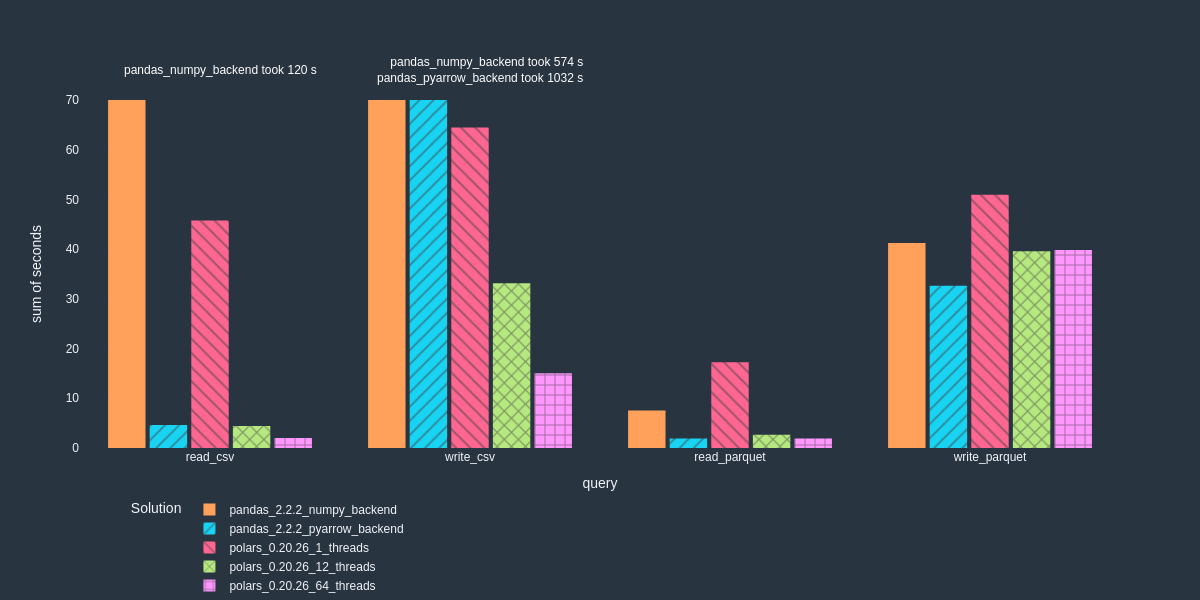

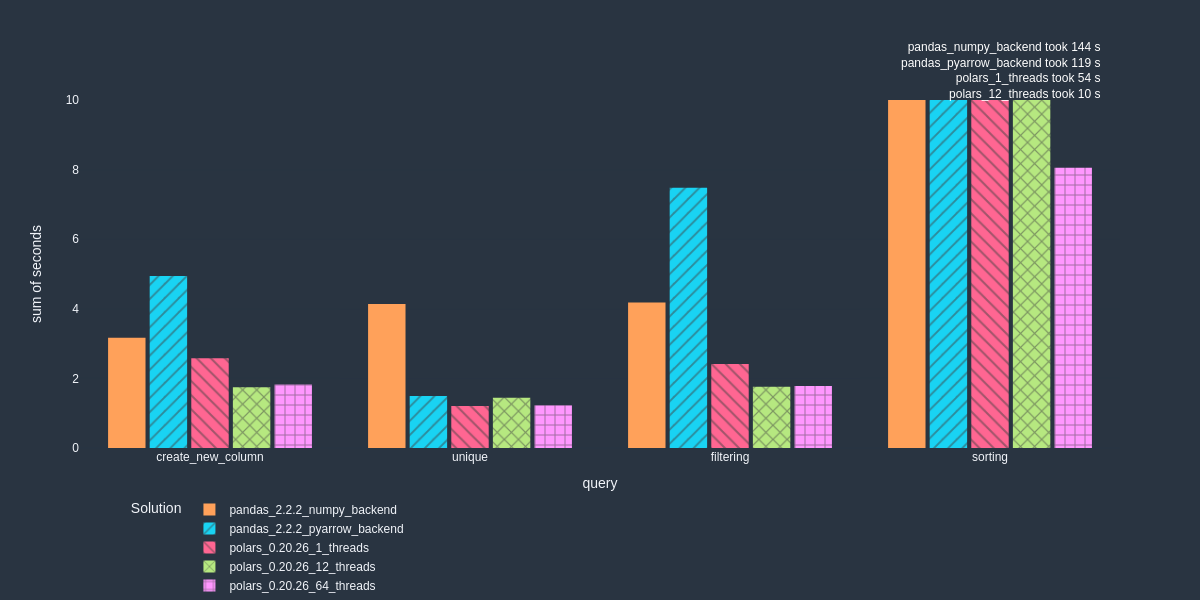

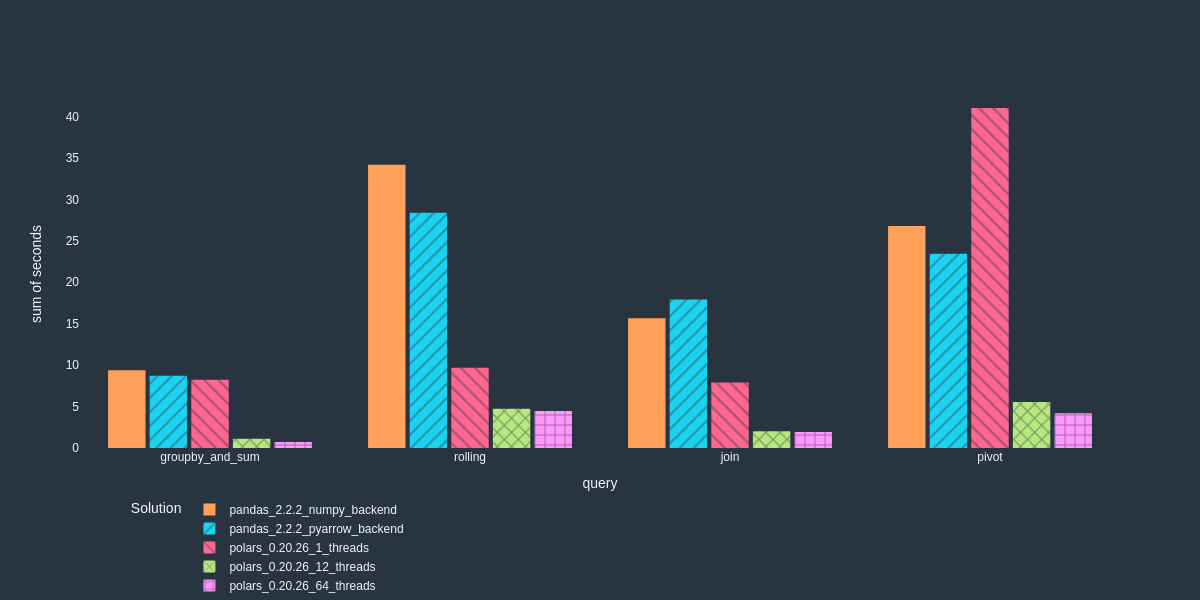